##### Context 

The health of women throughout pregnancy, childbirth, and the postpartum period is referred to as maternal health. Despite significant advancement over the past 20 years, 295 000 women died during or after pregnancy and childbirth in 2017. This number is unacceptably high. In addition to indirect factors including anaemia, and malaria, the most frequent direct causes of maternal injury and death are excessive blood loss, infection, and high blood pressure. Most maternal deaths are preventable with timely management by skilled professionals working together across different disciplines.


We are tasked to the analyze maternal health data provided, and identifying evidence based actions with an aim to improve health outcomes.We will be building a linear regression model for predicting the systolic BP and performing association rule on diastolic to systolic bp.

##### Import Librabries needed

In [122]:
# Libraries o help with reading and manipulating data
import numpy as np
import pandas as pd
%matplotlib inline
from warnings import filterwarnings
filterwarnings('ignore')
# libraries to help with data visulization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

# Remove the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_row", 200)

from sklearn.preprocessing import MinMaxScaler
# split to train and test
from sklearn.model_selection import train_test_split
# model
from sklearn.linear_model import LinearRegression, Lasso

# to check model performance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.decomposition import PCA

from mlxtend.feature_selection import SequentialFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs


from sklearn.cluster import KMeans

%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from imblearn.over_sampling import SMOTE


##### Define a function for training the model

In [2]:
# function to compute adjusted R-squared
def adj_r2_score(predictors, targets, predictions):
    r2 = r2_score(targets, predictions)
    n = predictors.shape[0]
    k = predictors.shape[1]
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))

# function to compute MAPE
def mape_score(targets, predictions):
    return np.mean(np.abs(targets - predictions) / targets) * 100


# function to compute different metrics to check performance of a regression model
def model_performance_regression(model, predictors, target):
    """
    Function to compute different metrics to check regression model performance

    model: regressor
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    r2 = r2_score(target, pred)  # to compute R-squared
    adjr2 = adj_r2_score(predictors, target, pred)  # to compute adjusted R-squared
    rmse = np.sqrt(mean_squared_error(target, pred))  # to compute RMSE
    mae = mean_absolute_error(target, pred)  # to compute MAE
    mape = mape_score(target, pred)  # to compute MAPE

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "RMSE": rmse,
            "MAE": mae,
            "R-squared": r2,
            "Adj. R-squared": adjr2,
            "MAPE": mape
        },
        index=[0],
    )

    return df_perf

##### define function for treating outliers

In [3]:
def treat_outliers(df, col):
    """
    treats outliers in a variable
    col:  str, name of the numerical variable
    df: data frame
    col: name of the column    
    """
    
    Q1 = df[col].quantile(0.25) #25th quantile
    Q3 = df[col].quantile(0.75) # 75th quantile
    IQR = Q3 - Q1
    
    Lower_Whisker = Q1 - 1.5 * IQR
    Upper_Whisker = Q3 + 1.5 * IQR
    
    df[col] = np.clip(df[col], Lower_Whisker, Upper_Whisker)
    # all the values smaller than Lower_whisker will be assigned value
    
    return df



def treat_outliers_all(df, col_list):
    """
    treat outlier in all numerical variables
    col_list: list of numerical variables
    df: data frame
    """
    
    for c in col_list:
        df = treat_outliers(df,c)
        
    return df


# The data set

We are provided with data set that has the following informations
- Age: showing the ages of the women under study
- Systolic BP: is the maximum pressure in the arteries during the contraction of the heart muscle. 
- Diastolic BP: is the minimum pressure in the arteries during the relaxation of the heart muscle between beats.
- BS: This is the measure of the blood sugar
- BodyTemp: present the body temperature of the women under study
- HeartRate: the heart rate the individuals
- RiskLevel: The susceptibility of risk for every indices provided

##### Load the Data

In [4]:
data = pd.read_excel('mhs.xls') # load the data
data.head() # check the head

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk


In [5]:
# check for null values
data.isnull().sum()

Age            0
SystolicBP     0
DiastolicBP    0
BS             0
BodyTemp       0
HeartRate      0
RiskLevel      0
dtype: int64

- From the above the data has no null values

In [6]:
data.info() # check the info to ascertain the data types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB


In [7]:
data.describe().T # see the statistic of the data

,count,mean,std,min,25%,50%,75%,max
Age,1014.0,29.871795,13.474386,10.0,19.0,26.0,39.0,70.0
SystolicBP,1014.0,113.198225,18.403913,70.0,100.0,120.0,120.0,160.0
DiastolicBP,1014.0,76.460552,13.885796,49.0,65.0,80.0,90.0,100.0
BS,1014.0,8.725986,3.293532,6.0,6.9,7.5,8.0,19.0
BodyTemp,1014.0,98.665089,1.371384,98.0,98.0,98.0,98.0,103.0
HeartRate,1014.0,74.301775,8.088702,7.0,70.0,76.0,80.0,90.0


##### Observations

- The Age has a minimum age of 10 and maximum age of 70.
- The median Age of the data provided is 26years, less than the mean showing that this is right skewed
- The miniun Systolic BP is 70 and the maximum is 160
- The median Systolic BP is 120, greater than the mean showing that this is left skewed
- The minimum Diastolic BP is 49.0 and maximum of 100
- The median Diastolic BP is 80.0 greater than the mean 76.5 showing that this is slightly left skewed
- The Blood Sugar has a minimum of 6.0 and maximum of 19.0 and the median is 7.5.
- The maximum Body Temperature is 103 and the minimum is 98
- The maximum Heartrate is 90 and the minimum is 7.0. This value of 7 is questionable 


In [8]:
data['HeartRate'].unique() # check the unique heart rates

array([86, 70, 80, 76, 78, 77, 88, 90, 66, 82, 60, 75, 67, 65, 68,  7],
      dtype=int64)


##### Note
- low, normal and high are <110, 110-140, >=140 respectively for the Systolic BP
- low, normal and high are <70, 70-90, >= 90 respectively for the Diastolic BP

In [9]:
data['RiskLevel'].unique()

array(['high risk', 'low risk', 'mid risk'], dtype=object)

In [10]:
# Replacing the values of the Risk Level to 0,1,2 to represent low risk, mid risk and high risk respectively
# using a dictionary to collect the details to replace and the value to assign to them
levels = {'high risk': 2,'low risk': 0,'mid risk': 1}
data['RiskLevel'].replace(levels, inplace = True)

In [11]:
# check
data.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,2
1,35,140,90,13.0,98.0,70,2
2,29,90,70,8.0,100.0,80,2
3,30,140,85,7.0,98.0,70,2
4,35,120,60,6.1,98.0,76,0


### Visualizations

120    0.442801
90     0.151874
140    0.118343
100    0.090730
130    0.059172
85     0.042406
110    0.018738
76     0.015779
95     0.011834
160    0.009862
75     0.007890
115    0.007890
70     0.006903
80     0.004931
135    0.002959
78     0.002959
83     0.001972
99     0.001972
129    0.000986
Name: SystolicBP, dtype: float64

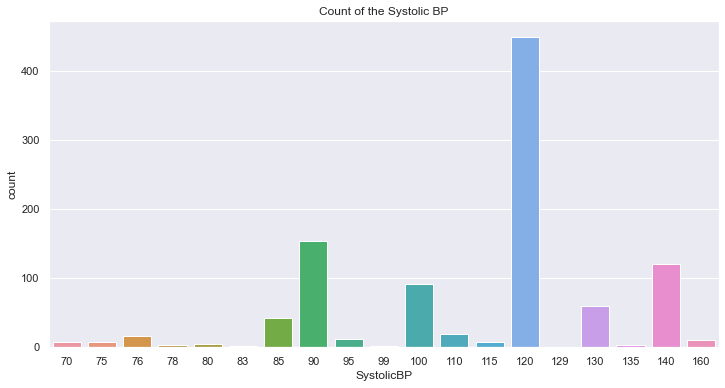

In [12]:
# check the counts of high low and normal rates in Systolic BP
plt.figure(figsize=(12,6))
sns.countplot(data = data, x = 'SystolicBP')
plt.title('Count of the Systolic BP')
data['SystolicBP'].value_counts(normalize=True)

From the Systolic BP diagram we observed that more women have normal BP rate

80     0.222880
60     0.171598
90     0.150888
70     0.098619
100    0.085799
65     0.085799
85     0.048323
75     0.037475
95     0.035503
49     0.024655
50     0.023669
63     0.007890
76     0.002959
68     0.001972
89     0.000986
69     0.000986
Name: DiastolicBP, dtype: float64

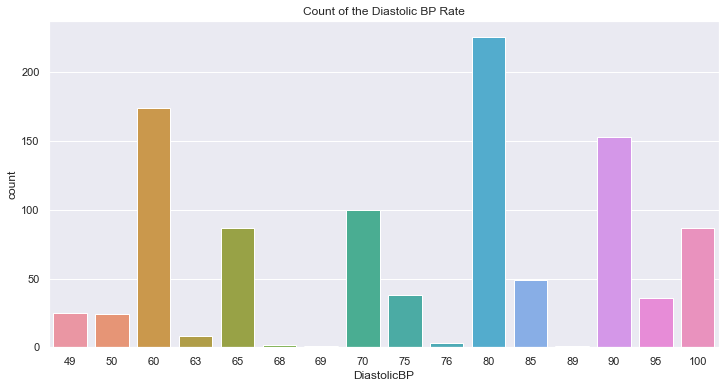

In [13]:
# check the counts of high low and normal rates in Diastolic BP Rate
plt.figure(figsize=(12,6))
sns.countplot(data = data, x = 'DiastolicBP')
plt.title('Count of the Diastolic BP Rate')
data['DiastolicBP'].value_counts(normalize=True)

The distribution of Diastolic BP rate shows that the rate of normal BP is higher from the population

Text(0.5, 1.0, 'Distribution of Blodd Sugar')

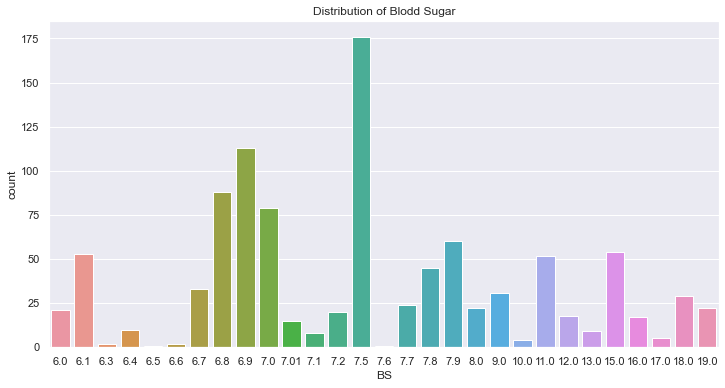

In [14]:
# check the blood sugar
plt.figure(figsize=(12,6))
sns.countplot(data = data, x = 'BS')
plt.title('Distribution of Blodd Sugar')

Text(0.5, 1.0, 'Distribution of BodyTemp')

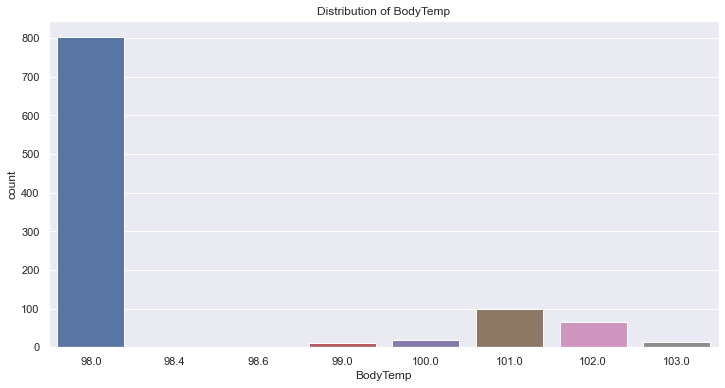

In [15]:
# check the Body Temperature
plt.figure(figsize=(12,6))
sns.countplot(data = data, x = 'BodyTemp')
plt.title('Distribution of BodyTemp')

Text(0.5, 1.0, 'Distribution of RiskLevel')

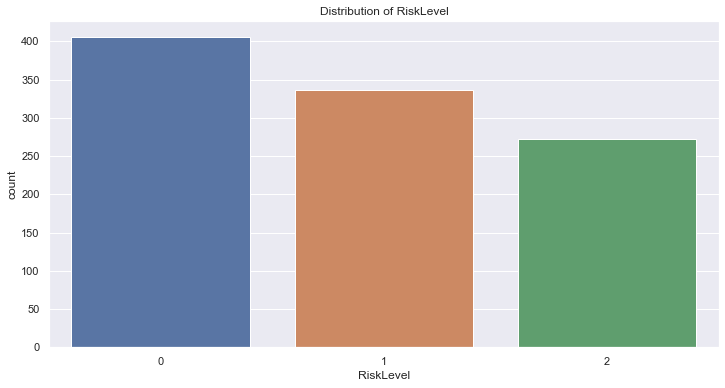

In [16]:
# check the Body Temperature
plt.figure(figsize=(12,6))
sns.countplot(data = data, x = 'RiskLevel')
plt.title('Distribution of RiskLevel')

Text(0.5, 1.0, 'Distribution of HeartRate')

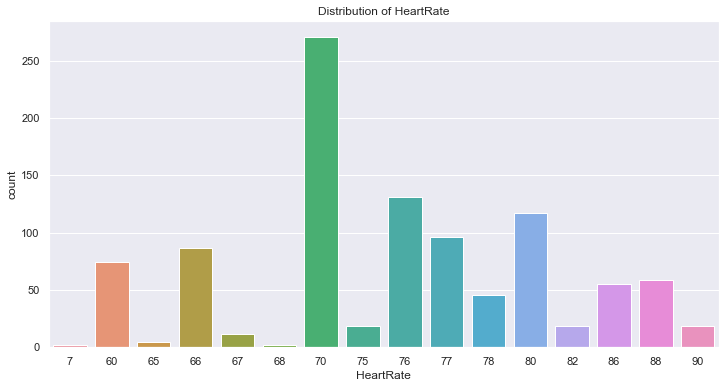

In [17]:
# check the Body Temperature
plt.figure(figsize=(12,6))
sns.countplot(data = data, x = 'HeartRate')
plt.title('Distribution of HeartRate')

Text(0.5, 1.0, 'SystolicBP and RiskLevel')

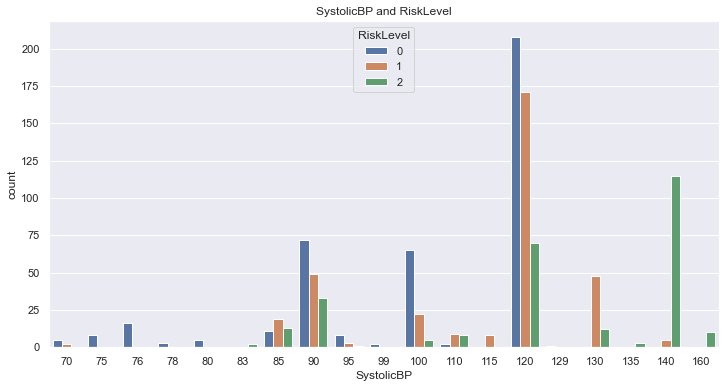

In [18]:
# relationship between the systolic BP and risk level
plt.figure(figsize =(12,6))
sns.countplot(data = data, x = 'SystolicBP', hue = 'RiskLevel')
plt.title('SystolicBP and RiskLevel')


Text(0.5, 1.0, 'DiastolicBP and RiskLevel')

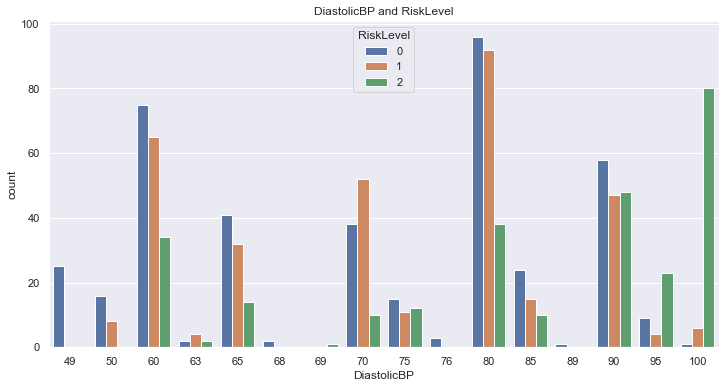

In [19]:
# relationship between the Diastolic BP and risk level
plt.figure(figsize =(12,6))
sns.countplot(data = data, x = 'DiastolicBP', hue = 'RiskLevel')
plt.title('DiastolicBP and RiskLevel')


Text(0.5, 1.0, 'Heart Rate and RiskLevel')

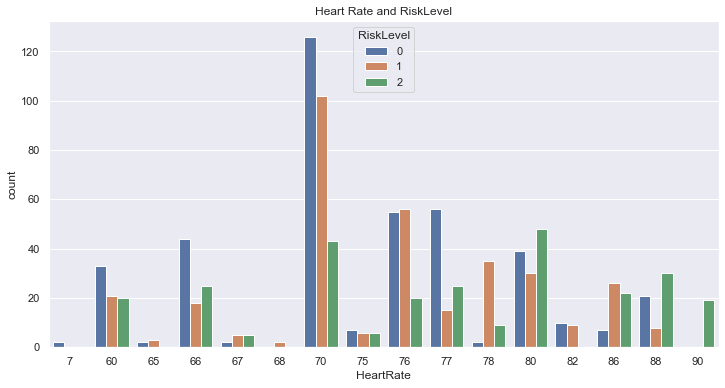

In [20]:
# relationship between the Heartrate and risk level
plt.figure(figsize =(12,6))
sns.countplot(data = data, x = 'HeartRate', hue = 'RiskLevel')
plt.title('Heart Rate and RiskLevel')

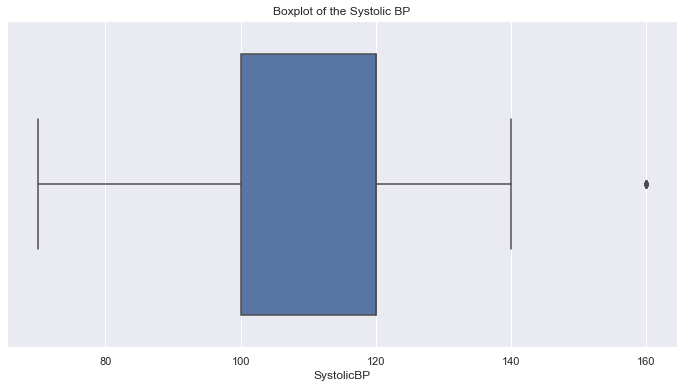

In [21]:
# Create a boxplot of SystolicBP
plt.figure(figsize =(12,6))
sns.boxplot(data=data, x="SystolicBP")
plt.title('Boxplot of the Systolic BP')
plt.show()


##### Observations

From the target boxplot, we observe that 160 systolic BP is the outlier and the BP rate of our dataset is between 40 - 140 and the majority of the rate is between 100-120

In [22]:
# choosing the features
data.columns

Index(['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate',
       'RiskLevel'],
      dtype='object')

In [23]:
# making copy of the data
df = data[['Age','DiastolicBP','BS','BodyTemp','HeartRate','RiskLevel','SystolicBP']]

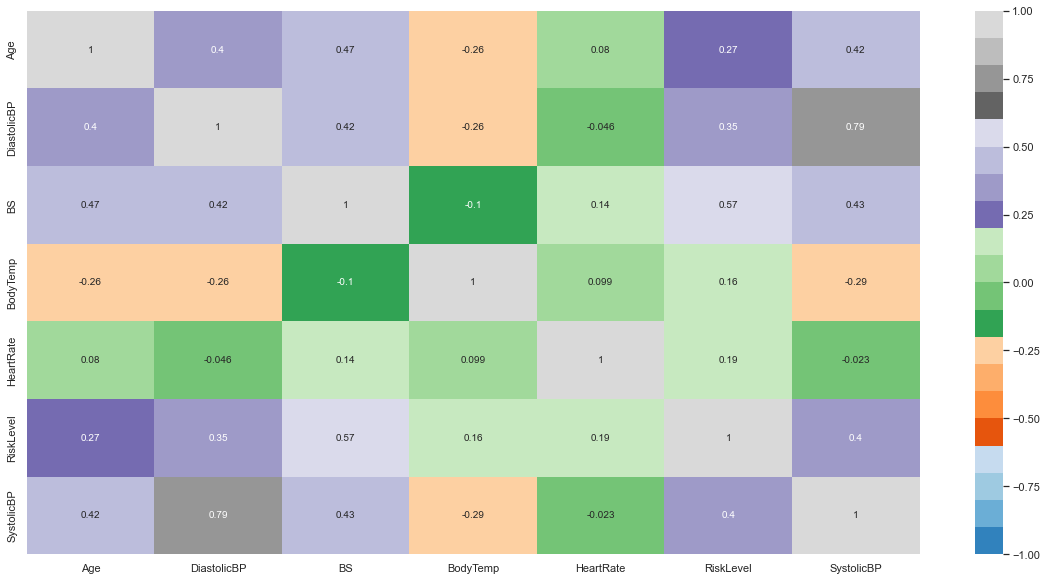

In [24]:
# plotting the heat diagram

plt.figure(figsize=(20,10))

corr =  df.corr()

corr = df.corr(method='pearson')
sns.heatmap(corr, annot=True,cmap='tab20c', vmin=-1, vmax=1)
plt.show()

##### Observations

From the heatmap

- The Diastolic BP has high correlation with the Systolic BP
- The body temperature and Heart rate have low correlation with the Systolic BP
- The other independent variables are moderately correlated to the Systolic BP

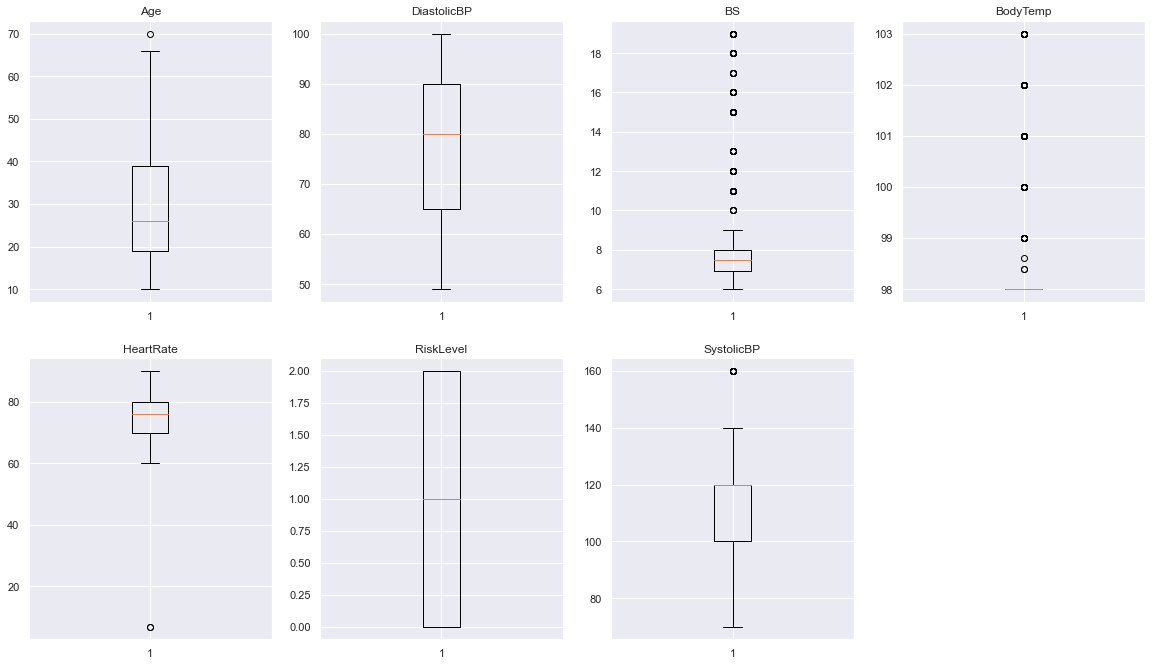

In [25]:
# check for outliers in the dats
plt.figure(figsize=(20, 30))

for i, variable in enumerate(df):
    plt.subplot(5,4, i +1)
    plt.boxplot(df[variable])
    plt.title(variable)

plt.show()

##### Observations

- There existis outliers in the Heartrate, Systolic BP, Body temperature and Blood Sugar
- We will build the model without treating the outliers and build another model after treating outliers to compare

##### Splitting the data

In [26]:
X = df.drop('SystolicBP', axis =1)

y = df['SystolicBP']

In [27]:
X.shape, y.shape# checking the shape of both the X and y variables

((1014, 6), (1014,))

In [28]:
X

,Age,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,80,15.0,98.0,86,2
1,35,90,13.0,98.0,70,2
2,29,70,8.0,100.0,80,2
3,30,85,7.0,98.0,70,2
4,35,60,6.1,98.0,76,0
...,...,...,...,...,...,...
1009,22,60,15.0,98.0,80,2
1010,55,90,18.0,98.0,60,2
1011,35,60,19.0,98.0,86,2
1012,43,90,18.0,98.0,70,2


In [29]:
 # split to train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) # using 20% of the data for testing

In [30]:
print("Number of rows in train data =", X_train.shape[0])
print('Number of rows in test data =', X_test.shape[0])

Number of rows in train data = 811
Number of rows in test data = 203


##### Normalize the data

In [31]:
# create an instance of the scaler
scaler = MinMaxScaler()

In [32]:
X_train_sc = scaler.fit_transform(X_train) # scaled train data
X_test_sc = scaler.transform(X_test) # scaled test data

##### Building the model

In [33]:
#creating instance of the model

lin_reg = LinearRegression()

In [34]:
# Training the model

lin_reg.fit(X_train_sc,y_train )

LinearRegression()

In [35]:
lin_reg.coef_ # The model coefficients.

array([ 6.4349766 , 45.31444809,  2.48649066, -7.17920662, -4.49943321,
        6.8659804 ])

#### Observations from the model coefficients

- Given that every other variables remains constant, a 7.2 unit increase in the age of the women will produce a change in the Systolic BP

- 45.1 unit increase in the Diastolic BP will produce change in the Systolic BP, having other varibles constant
- 0.05 unit increase in the blood sugar will produce change in the Systolic BP, given that other variables remains constant
- -0.81 unit decrease in the heart rate will produce change in the Systolic BP, given that other variables remains constant

In [36]:
model_train = model_performance_regression(lin_reg, X_train_sc, y_train)

In [37]:
model_train

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,10.5428,8.381557,0.670355,0.667895,7.719724


##### Observations from the trained model

- The model is making a RMSE error of 10.5 and a mean absolute error of 8.4
- We have a R-squared of 67% and adjusted R squared of 66% in predicting the Systolic BP
- We can improve our model to reduce the error and Adjusted R-squared

In [38]:
# applying to the test data
model_test = model_performance_regression(lin_reg, X_test_sc, y_test)

In [39]:
model_test

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,11.63507,9.282426,0.605092,0.593003,8.565452


##### Observations from the test model

- The model is making a RMSE error of 11.6 and a mean absolute error of 9.3
- We have a R-squared of 60% and adjusted R squared of 59% in predicting the Systolic BP

In [40]:
print("Training Accuracy: {:.3f}".format(lin_reg.score(X_train_sc, y_train)))
print("Test Accuracy: {:.3f}".format(lin_reg.score(X_test_sc, y_test)))

Training Accuracy: 0.670
Test Accuracy: 0.605


In [41]:
pred = lin_reg.predict(X_test_sc)
r2_score(y_test,pred)

0.6050924236737121

##### Benchmarking our features to 0.4 correlation with the Systolic BP from the heat map

In [42]:
# features with 0.4 corr with the systolic bp
df_1 = df[['Age','DiastolicBP','BS','RiskLevel', 'SystolicBP']]

In [43]:
X = df_1.drop('SystolicBP', axis =1)

y = df_1['SystolicBP']

In [44]:
X

,Age,DiastolicBP,BS,RiskLevel
0,25,80,15.0,2
1,35,90,13.0,2
2,29,70,8.0,2
3,30,85,7.0,2
4,35,60,6.1,0
...,...,...,...,...
1009,22,60,15.0,2
1010,55,90,18.0,2
1011,35,60,19.0,2
1012,43,90,18.0,2


In [45]:
 # split to train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) # using 20% of the data for testing

In [46]:
print("Number of rows in train data =", X_train.shape[0])
print('Number of rows in test data =', X_test.shape[0])

Number of rows in train data = 811
Number of rows in test data = 203


##### Normalize the data

In [47]:
# create an instance of the scaler
scaler = MinMaxScaler()

In [48]:
X_train_sc = scaler.fit_transform(X_train) # scaled train data
X_test_sc = scaler.transform(X_test) # scaled test data

##### Building the model

In [49]:
#creating instance of the model

lin_reg = LinearRegression()

In [50]:
# Training the model

lin_reg.fit(X_train_sc,y_train )

LinearRegression()

In [51]:
model_train_1 = model_performance_regression(lin_reg, X_train_sc, y_train)

In [52]:
model_train_1

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,10.71043,8.554163,0.659789,0.658101,7.890341


##### Observations from the trained model

- The model is making a RMSE error of 10.7 and a mean absolute error of 8.5
- We have a R-squared of 65% and adjusted R squared of 65% in predicting the Systolic BP
- We can improve our model to reduce the error and Adjusted R-squared

In [53]:
# applying to the test data
model_test_1 = model_performance_regression(lin_reg, X_test_sc, y_test)

In [54]:
model_test_1

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,11.915312,9.636408,0.58584,0.577473,8.870816


##### Observations from the test model

- The model is making a RMSE error of 11.9 and a mean absolute error of 9.6
- We have a R-squared of 58% and adjusted R squared of 57% in predicting the Systolic BP
- We can improve our model to reduce the error and Adjusted R-squared

##### Treating the outliers and building the model

In [55]:
# treating the outliers

df_2 = treat_outliers_all(df, df)

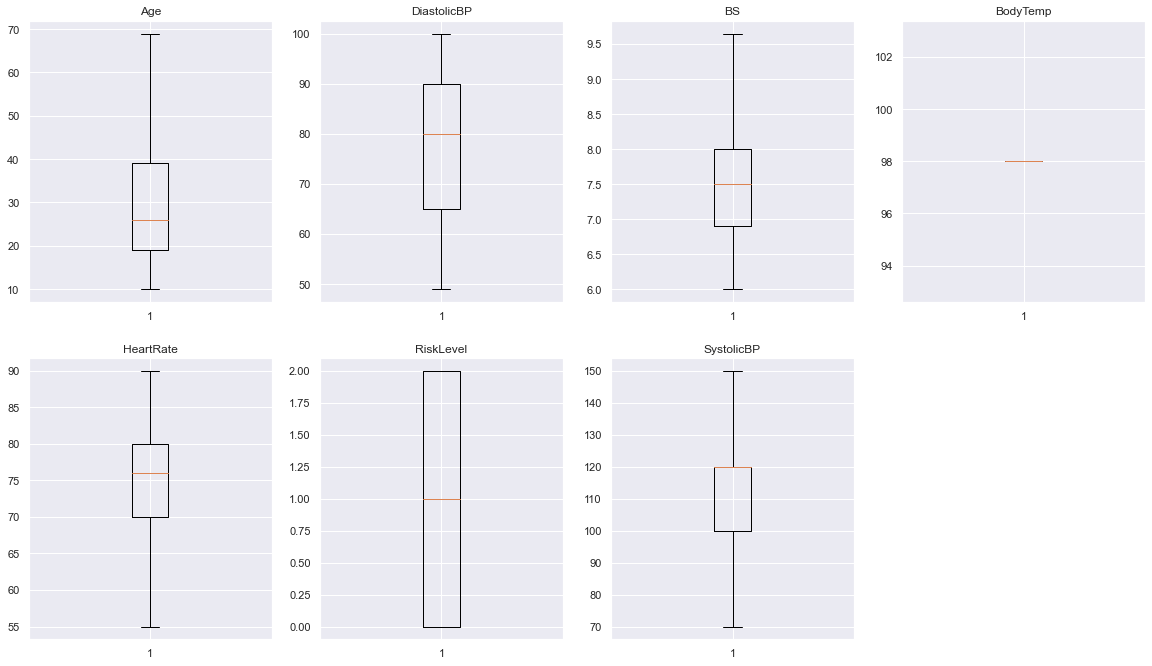

In [56]:
# view the treated outliers
plt.figure(figsize=(20,30))

for i, variable in enumerate(df):
    plt.subplot(5,4,i+1)
    plt.boxplot(df[variable], whis = 1.5)
    plt.title(variable)
    
plt.show()

In [57]:
# split to X and y
X = df_2.drop('SystolicBP', axis =1)

y = df_2['SystolicBP']

In [58]:
 # split to train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) # using 20% of the data for testing

In [59]:
print("Number of rows in train data =", X_train.shape[0])
print('Number of rows in test data =', X_test.shape[0])

Number of rows in train data = 811
Number of rows in test data = 203


##### Normalize the data

In [60]:
# create an instance of the scaler
scaler = MinMaxScaler()

In [61]:
X_train_sc = scaler.fit_transform(X_train) # scaled train data
X_test_sc = scaler.transform(X_test) # scaled test data

##### Build the model

In [62]:
#creating instance of the model

lin_reg = LinearRegression()

In [63]:
# Training the model

lin_reg.fit(X_train_sc,y_train )

LinearRegression()

In [64]:
model_train_2= model_performance_regression(lin_reg, X_train_sc, y_train)
model_train_2

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,10.473364,8.33083,0.666542,0.664053,7.687103


##### Observations from the trained model

- The model is making a RMSE error of 10.4 and a mean absolute error of 8.3
- We have a R-squared of 66% and adjusted R squared of 66% in predicting the Systolic BP
- We can improve our model to reduce the error and Adjusted R-squared

In [65]:
# applying to the test data
model_test_2 = model_performance_regression(lin_reg, X_test_sc, y_test)
model_test_2

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,11.396303,9.158318,0.611681,0.599794,8.457872


##### Observations from the test model

- The model is making a RMSE error of 11.3 and a mean absolute error of 9.1
- We have a R-squared of 61% and adjusted R squared of 59% in predicting the Systolic BP
- We can improve our model to reduce the error and Adjusted R-squared

##### Benchmarking our features to 0.4 correlation with the Systolic BP from the heat map

In [66]:
# features with 0.4 corr with the systolic bp
df_3 = df_2[['Age','DiastolicBP','BS','RiskLevel', 'SystolicBP']]

In [67]:
X = df_3.drop('SystolicBP', axis =1)

y = df_3['SystolicBP']

In [68]:
 # split to train and test data
X_train_v, X_test_v, y_train_v, y_test_v = train_test_split(X, y, test_size=0.2, random_state=0) # using 20% of the data for testing

##### Normalize the data

In [69]:
# create an instance of the scaler
scaler = MinMaxScaler()

In [70]:
X_train_s = scaler.fit_transform(X_train_v) # scaled train data
X_test_s = scaler.transform(X_test_v) # scaled test data

##### Build the model

In [71]:
#creating instance of the model

lin_reg = LinearRegression()

In [72]:
# Training the model

lin_reg.fit(X_train_s,y_train_v )

LinearRegression()

In [73]:
model_train_3= model_performance_regression(lin_reg, X_train_s, y_train_v)
model_train_3

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,10.47378,8.329035,0.666515,0.66486,7.686362


##### Observations from the trained model

- The model is making a RMSE error of 10.4 and a mean absolute error of 8.3
- We have a R-squared of 66% and adjusted R squared of 66% in predicting the Systolic BP
- We can improve our model to reduce the error and Adjusted R-squared

In [74]:
# applying to the test data
model_test_3 = model_performance_regression(lin_reg, X_test_s, y_test_v)
model_test_3

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,11.397162,9.157717,0.611623,0.603777,8.458817


##### Observations from the test model

- The model is making a RMSE error of 11.3 and a mean absolute error of 9.1
- We have a R-squared of 61% and adjusted R squared of 60% in predicting the Systolic BP
- We can improve our model to reduce the error and Adjusted R-squared

 ### Forward Feature Selection

In [75]:
# initializing the sequential feature selector with hyper-parameters
sfx = SequentialFeatureSelector(estimator= lin_reg,
                               k_features= X_train.shape[1],
                               n_jobs= -1,
                               verbose= 2)
sfx.fit(X_train_sc, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    7.2s remaining:    7.2s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    7.4s finished

[2023-05-12 10:58:56] Features: 1/6 -- score: 0.6255976590267925[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished

[2023-05-12 10:58:56] Features: 2/6 -- score: 0.6407321417113477[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.0s finished

[2023-05-12 10:58:57] Features: 3/6 -- score: 0.6511513005124303[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished

[2023-05-12 10:58:57] Features: 4/6 -- score: 0.65598393492297[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent worker

SequentialFeatureSelector(estimator=LinearRegression(), k_features=(6, 6),
                          n_jobs=-1, scoring='r2', verbose=2)

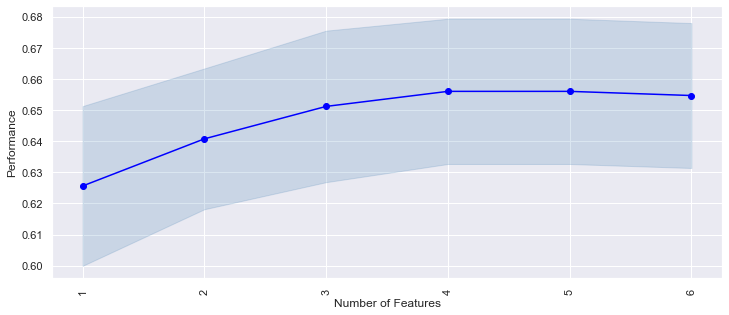

In [76]:
# visualizing to choose the number of features
fig1 = plot_sfs(sfx.get_metric_dict(), kind="std_err", figsize = (12, 5))
plt.xticks(rotation = 90)
plt.show()

In [77]:
# applyin the 4 features to the sequential feature selector
sfs = SequentialFeatureSelector(estimator=lin_reg,
                               k_features=4,
                               n_jobs=-1,
                               verbose=2)
sfs.fit(X_train_sc, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished

[2023-05-12 10:58:57] Features: 1/4 -- score: 0.6255976590267925[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished

[2023-05-12 10:58:57] Features: 2/4 -- score: 0.6407321417113477[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.0s finished

[2023-05-12 10:58:57] Features: 3/4 -- score: 0.6511513005124303[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished

[2023-05-12 10:58:58] Features: 4/4 -- score: 0.65598393492297

SequentialFeatureSelector(estimator=LinearRegression(), k_features=(4, 4),
                          n_jobs=-1, scoring='r2', verbose=2)

In [78]:
feat_cols = list(sfs.k_feature_idx_) #index of the feature in the original data, converting it to list

In [79]:
feat_cols

[0, 1, 2, 5]

##### These are the index of the 4 important features to the model
0 - Age

1 - Diastolic BP

2 - Blood Sugar

5 - Risk Level

In [80]:
# select the important features in training and test sets
X_train_new = X_train[X_train.columns[feat_cols]]
X_test_new = X_test[X_train.columns[feat_cols]]

In [81]:
# we also need to normalize the new train and test sets


scaler_new = MinMaxScaler() #instance
X_train_new_sc = scaler_new.fit_transform(X_train_new)
X_test_new_sc = scaler_new.transform(X_test_new)

### Re-build the models with the new features

In [82]:
lin_reg2 = LinearRegression()
lin_reg2.fit(X_train_new_sc,y_train)

LinearRegression()

In [83]:
model_train_4= model_performance_regression(lin_reg2, X_train_new_sc, y_train)
model_train_4

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,10.47378,8.329035,0.666515,0.66486,7.686362


##### Observations from the train model

- The model is making a RMSE error of 10.4 and a mean absolute error of 8.3
- We have a R-squared of 66% and adjusted R squared of 66% in predicting the Systolic BP


In [84]:
# applying to the test data
model_test_4 = model_performance_regression(lin_reg, X_test_new_sc, y_test)
model_test_4

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,11.397162,9.157717,0.611623,0.603777,8.458817


##### Observations from the test model
- The model is making a RMSE error of 11.3 and a mean absolute error of 9.1
- We have a R-squared of 61% and adjusted R squared of 60% in predicting the Systolic BP

### Applying PCA

In [85]:
df_2.columns

Index(['Age', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate', 'RiskLevel',
       'SystolicBP'],
      dtype='object')

In [86]:
feat = ['Age', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate', 'RiskLevel']

x = df_2.loc[:, feat].values
y = df_2.loc[:,['SystolicBP']].values
x = MinMaxScaler().fit_transform(x)

x

array([[0.25423729, 0.60784314, 1.        , 0.        , 0.88571429,
        1.        ],
       [0.42372881, 0.80392157, 1.        , 0.        , 0.42857143,
        1.        ],
       [0.3220339 , 0.41176471, 0.54794521, 0.        , 0.71428571,
        1.        ],
       ...,
       [0.42372881, 0.21568627, 1.        , 0.        , 0.88571429,
        1.        ],
       [0.55932203, 0.80392157, 1.        , 0.        , 0.42857143,
        1.        ],
       [0.37288136, 0.31372549, 0.        , 0.        , 0.6       ,
        0.5       ]])

In [87]:
#Now that we've standardized the values of the variables, we will apply the PCA.

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
New_df = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])

New_df

,PC1,PC2
0,0.739873,0.260944
1,0.791925,-0.064132
2,0.443923,0.399980
3,0.367883,0.170216
4,-0.632608,0.054168
...,...,...
1009,0.589412,0.504357
1010,0.839737,-0.289294
1011,0.657354,0.449251
1012,0.822846,-0.124997


In [88]:
#We will recombine the principal components with the targets now.

Final_df = pd.concat([New_df, df[['SystolicBP']]], axis = 1)

Final_df

,PC1,PC2,SystolicBP
0,0.739873,0.260944,130.0
1,0.791925,-0.064132,140.0
2,0.443923,0.399980,90.0
3,0.367883,0.170216,140.0
4,-0.632608,0.054168,120.0
...,...,...,...
1009,0.589412,0.504357,120.0
1010,0.839737,-0.289294,120.0
1011,0.657354,0.449251,85.0
1012,0.822846,-0.124997,120.0


In [89]:
#Let's see how much of the variance is explained.

pca.explained_variance_ratio_

array([0.54611819, 0.1659764 ])

In [90]:
# splitting the data
X = Final_df.drop(['SystolicBP'], axis = 1)
y = Final_df['SystolicBP']

In [91]:
 # split to train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) # using 20% of the data for testing

In [92]:
#creating instance of the model

lin_reg = LinearRegression()

In [93]:
# Training the model

lin_reg.fit(X_train,y_train )

LinearRegression()

In [94]:
model_train_5= model_performance_regression(lin_reg, X_train, y_train)
model_train_5

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,12.605643,10.457168,0.516942,0.515747,9.754754


##### Observations from the train model
- The model is making a RMSE error of 12.6 and a mean absolute error of 10.4
- We have a R-squared of 51% and adjusted R squared of 51% in predicting the Systolic BP

In [95]:
# applying to the test data
model_test_5 = model_performance_regression(lin_reg, X_test, y_test)
model_test_5

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,14.036591,12.065414,0.410907,0.405016,11.204778


##### Observations from the train model
- The model is making a RMSE error of 14.0 and a mean absolute error of 12.0
- We have a R-squared of 41% and adjusted R squared of 40% in predicting the Systolic BP

In [96]:
Models = ['Model', 'Model_1', 'Model_2','Model_3','Model_4']
accuracy = [67.0,65.9,66.6,66.6,66.6]

dict = {'Models': Models,
       'Accuracy': accuracy}

df_model = pd.DataFrame(dict)
df_model

,Models,Accuracy
0,Model,67.0
1,Model_1,65.9
2,Model_2,66.6
3,Model_3,66.6
4,Model_4,66.6


### The relationship between age and heartrate  by means of age grouping.

In [97]:
# getting the age and heartrate into one dataframe
df_ah= df[['Age', 'HeartRate']]
df_ah.head()

,Age,HeartRate
0,25.0,86.0
1,35.0,70.0
2,29.0,80.0
3,30.0,70.0
4,35.0,76.0


In [98]:
# choosing bins
bins = [10, 20, 30, 40, 50,60,70]

df_ah['age_range'] = pd.cut(df_ah['Age'], bins)

In [99]:
# grouping with the bins
df_ah = (df_ah.groupby('age_range')['HeartRate'].agg(mean_heart_rate='mean')).reset_index()
df_ah

,age_range,mean_heart_rate
0,"(10, 20]",73.053872
1,"(20, 30]",75.165079
2,"(30, 40]",74.956284
3,"(40, 50]",76.458333
4,"(50, 60]",71.931034
5,"(60, 70]",79.250000


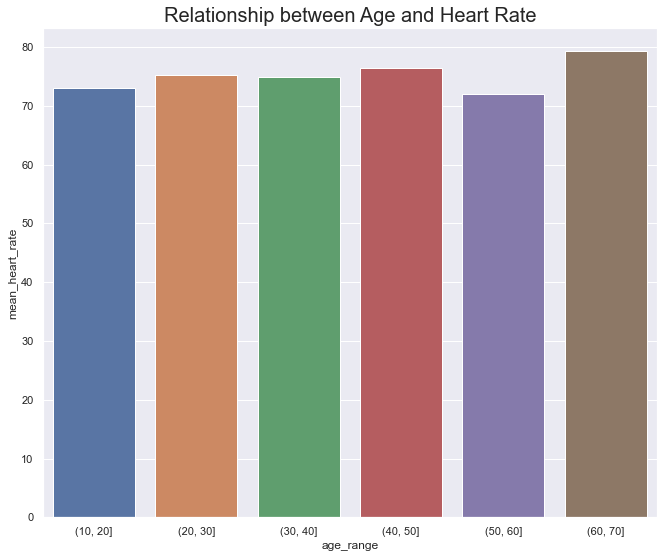

In [100]:
fig = plt.figure(figsize=(11, 9))

sns.barplot(x = df_ah["age_range"], y = df_ah["mean_heart_rate"])
plt.title("Relationship between Age and Heart Rate", size=20)
plt.show()

Describe how would you investigate associations between pairs high/high, normal/normal, and low/low diastolic and systolic blood pressure.  
Calculate, and interpret the following:
(1)    Support
(2)    Confidence
(3)    Conviction
(4)    Lift


Assume, the high systolic blood pressure starts from 140, the high diastolic blood pressure starts from 90. The normal systolic pressure is in the range (110, 140). The normal diastolic blood pressure is in the range (70, 90). The low systolic pressure is lower than 110, and low diastolic is less than 70.

##### Calculating the  Support

In [101]:
# select where the SystolicBP and DiastolicBP are high
df_high = df[(df['SystolicBP']>= 140) & (df['DiastolicBP']>=90)]

In [102]:
support_high = len(df_high) / len(df)
print(f' Support for this high Diastolic and Systolic BP is {support_high:.2f}')


 Support for this high Diastolic and Systolic BP is 0.12


In [103]:
# select where the SystolicBP and DiastolicBP are low
df_low = df[(df['SystolicBP']< 110) & (df['DiastolicBP']<70)]

In [104]:
support_low = len(df_low) / len(df)
print(f' Support for this low Diastolic and Systolic BP is {support_low:.2f}')


 Support for this low Diastolic and Systolic BP is 0.27


In [105]:
# slicing to get the normal BP rates
df_normal = df[(df['SystolicBP'] >= 110) & (df['SystolicBP'] < 140) &(df['DiastolicBP']>=70) & (df['DiastolicBP']<90)]

In [106]:
support_normal = len(df_normal) / len(df)
print(f' Support for this normal Diastolic and Systolic BP is {support_normal:.2f}')


 Support for this normal Diastolic and Systolic BP is 0.34


##### Calculating the  Confidence

In [107]:
# get the frequence of high for both diastolic and systolic BP
freq_sys_h = df[(df['SystolicBP'] >= 140)] # frequency of high systolic BP
freq_dia_h = df[(df['DiastolicBP']>=90)] # frequency of high diastolic BP

In [108]:
confidence_high = len(df_high) / len(freq_dia_h)
print(f' Confidence for this high Diastolic and Systolic BP is {confidence_high:.2f}')

 Confidence for this high Diastolic and Systolic BP is 0.42


In [109]:
# get the frequence of low for both diastolic and systolic BP
freq_sys_l = df[(df['SystolicBP'] < 110)] # frequency of low systolic BP
freq_dia_l = df[(df['DiastolicBP']<70)] # frequency of low diastolic BP

In [110]:
confidence_low = len(df_low) / len(freq_dia_l)
print(f' Confidence for this low Diastolic and Systolic BP is {confidence_low:.2f}')

 Confidence for this low Diastolic and Systolic BP is 0.84


In [111]:
# get the frequence of normal for both diastolic and systolic BP
freq_sys_n = df[(df['SystolicBP'] >= 110) & (df['SystolicBP']<140)] # frequency of normal systolic BP
freq_dia_n = df[(df['DiastolicBP']>=70)&(df['DiastolicBP']<90)] # frequency of normal diastolic BP

In [112]:
confidence_normal = len(df_normal) / len(freq_dia_n)
print(f' Confidence for this normal Diastolic and Systolic BP is {confidence_normal:.2f}')

 Confidence for this normal Diastolic and Systolic BP is 0.82


##### Calculating the Completeness

In [113]:
# completeness for high-high
completeness_high = len(df_high) / len(freq_sys_h)
print(f' Completeness for this high Diastolic and Systolic BP is {completeness_high:.2f}')

 Completeness for this high Diastolic and Systolic BP is 0.90


In [114]:
# completeness for low-low
completeness_low = len(df_low) / len(freq_sys_l)
print(f' Completeness for this low Diastolic and Systolic BP is {completeness_low:.2f}')

 Completeness for this low Diastolic and Systolic BP is 0.78


In [115]:
# completeness for normal -normal
completeness_norm = len(df_normal) / len(freq_sys_n)
print(f' Completeness for this normal Diastolic and Systolic BP is {completeness_norm:.2f}')

 Completeness for this normal Diastolic and Systolic BP is 0.63


##### Calculating for Conviction

In [116]:
# conviction for high-high

support_high_sys = len(freq_sys_h)/ len(df)
support_high_dia = len(freq_dia_h) / len(df)
conf_1 = len(df_high) / len(freq_dia_h)
conf_2 = len(df_high) / len(freq_sys_h)

conv_high = (1 - support_high_sys)/(1-conf_1)
print(f' Conviction for this high Diastolic and Systolic BP is {conv_high:.2f}')

 Conviction for this high Diastolic and Systolic BP is 1.51


In [117]:
# conviction for low-low

support_low_sys = len(freq_sys_l)/ len(df)
support_low_dia = len(freq_dia_l) / len(df)
conf_1 = len(df_low) / len(freq_dia_l)
conf_2 = len(df_low) / len(freq_sys_l)

conv_low = (1 - support_low_sys)/(1-conf_1)
print(f' Conviction for this low Diastolic and Systolic BP is {conv_low:.2f}')

 Conviction for this low Diastolic and Systolic BP is 4.16


In [118]:
# conviction for normal-normal

support_norm_sys = len(freq_sys_n)/ len(df)
support_norm_dia = len(freq_dia_n) / len(df)
conf_1 = len(df_normal) / len(freq_dia_n)
conf_2 = len(df_normal) / len(freq_sys_n)

conv_norm = (1 - support_norm_sys)/(1-conf_1)
print(f' Conviction for this normal Diastolic and Systolic BP is {conv_norm:.2f}')

 Conviction for this normal Diastolic and Systolic BP is 2.53


##### Calculating the Lift

In [119]:
# lift for high - high

lift_high = support_high / (support_high_dia * support_high_sys)
print(f' Lift for this high Diastolic and Systolic BP is {lift_high:.2f}')

 Lift for this high Diastolic and Systolic BP is 3.31


In [120]:
# lift for low - low

lift_low = support_low / (support_low_dia * support_low_sys)
print(f' Lift for this low Diastolic and Systolic BP is {lift_low:.2f}')

 Lift for this low Diastolic and Systolic BP is 2.48


In [121]:
# lift for normal - normal

lift_norm = support_normal / (support_norm_dia * support_norm_sys)
print(f' Lift for this normal Diastolic and Systolic BP is {lift_norm:.2f}')

 Lift for this normal Diastolic and Systolic BP is 1.53


##### Correlation between Age and Systolic BP.
The heat map in Heatmap displays the degrees of association between individual variables of the data set. The correlation between Age and systolic BP is 0.42, there is moderate positive correlation between the two variables, an increase in age can directly cause increase in systolic bp (This increase may not be linear). 


##### Conclusion.
We have built a model that have 64% performance in predicting the systolic blood pressure for pregnant women. The reduction of maternal mortality is of focus and this study has provided areas that can be monitored to reduce maternal mortality. From the result of the associated rule, we noticed that the lift score was above 1, which signifies that diastolic bp and systolic bp are dependent on one another and a useful association rule. Hypertensive disorders affect women and child in the womb and constant monitoring can reduce critical conditions in pregnant women. This study also provided insight on age and systolic bp, from their correlation we observed that they are moderately positively correlated, same amount of care should be given to women of any age during pregnancy. Below are some recommendations on how to improve maternal health.
- a.	Educating women on pregnancy and the importance of reporting changes.
- b.	Constant monitoring of blood pressure.

Further study can be made to ascertain the changes in blood pressure during and day and night during pregnancy, this is to determine the rates when at rest and when the body is in motion.
